# 情緒分析
**Author:** 李畇彤<br>
**Date created:** 2023/04/09<br>
**Last modified:** 2023/04/09<br>

## 大綱
+ CKIP 標註
    + 1. 將抓取結果用CKIP進行處理
    + 2. 探索分析 - NER
    + 3. 探索分析 - POS
+ 利用SnowNLP進行情緒分析

In [1]:
from ckiptagger import data_utils, construct_dictionary, WS, POS, NER
import configparser, re, os, io

from wordcloud import WordCloud, ImageColorGenerator

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from datetime import datetime, timedelta

## CKIP 標註

In [11]:
#data_utils.download_data_gdown("./") # gdrive-ckip # 下載ckip model

Downloading...
From (uriginal): https://drive.google.com/uc?id=1efHsY16pxK0lBD2gYCgCTnv1Swstq771
From (redirected): https://drive.google.com/uc?id=1efHsY16pxK0lBD2gYCgCTnv1Swstq771&confirm=t&uuid=3810bdad-280f-4b11-990d-992571ef784f
To: d:\Programs\Python\NSYSU\MIS581_SocialMediaAnalysis\data.zip
100%|██████████| 1.88G/1.88G [08:24<00:00, 3.72MB/s]


透過ckip這個套件可以對文集進行斷詞、命名實體辨識、詞性標記等處理
+ CKIP 標註任務
    + 斷詞（ws）
        + 可以設定自己的辭典
            + `recommend_dictionary` 推薦字典
            + `coerce_dictionary` 強制字典
    + 實體辨識（ner）
    + 詞性標註（pos）
+ NER與POS名詞對應: https://ckip.iis.sinica.edu.tw/service/corenlp/ （左上角的標記列表）

In [12]:
# 將三份工具的模型路徑指向我們剛才下載的 data.zip
ws = WS("./data")
pos = POS("./data")
ner = NER("./data")

c:\Users\s2568\AppData\Local\Programs\Python\Python39\lib\site-packages\ckiptagger\model_ws.py:106: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  cell = tf.compat.v1.nn.rnn_cell.LSTMCell(hidden_d, name=name)
c:\Users\s2568\AppData\Local\Programs\Python\Python39\lib\site-packages\ckiptagger\model_pos.py:56: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  cell = tf.compat.v1.nn.rnn_cell.LSTMCell(hidden_d, name=name)
c:\Users\s2568\AppData\Local\Programs\Python\Python39\lib\site-packages\ckiptagger\model_ner.py:57: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by th

### 1. 將抓取結果用CKIP進行處理

資料來源：
+ 工作流程平台蒐集PTT 科技工作(Tech_Job)文章
+ 關鍵字:「求職」、「裁員」(1688筆)
+ 時間: 2018-01-01 ~ 2023-01-01

In [10]:
df = pd.read_csv("data/Tech_Job_OriginalData.csv")
df.head(3)

,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource
0,1,https://www.ptt.cc/bbs/Tech_Job/M.1514831112.A...,[請益]研替offer（類比科/力智/鈺創/瑞鼎）,2018-01-01 18:19:10,elohaxup6xl3,Tech_Job,各位年薪千萬的大大好，新年快樂。\n小弟是第一次發文的新鮮人\n目前研替面試一個段落\n拿到...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""hsucheng"", ""...",223.141.230.104,2018-04-27 12:51:21,ptt
1,2,https://www.ptt.cc/bbs/Tech_Job/M.1514853292.A...,[新聞]【掙扎片】年薪百萬的科技人 卻因這幾點,2018-01-02 00:28:49,Angels5566,Tech_Job,有網友在mobile01分享，自己在科技業已工作9年，年薪約百萬，但最近老婆還是希望他\n去...,"[{""cmtStatus"": ""→"", ""cmtPoster"": ""latin0126"", ...",113.196.174.254,2018-04-27 12:51:21,ptt
2,3,https://www.ptt.cc/bbs/Tech_Job/M.1515382875.A...,[徵才]高雄昇雷科技股份有限公司誠徵工程師,2018-01-08 03:35:11,qqgreenmoon,Tech_Job,【公司名稱】\n昇雷科技股份有限公司\n\n【工作職缺】\n1、硬體工程師\n2、系統工程師...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""ohmypig"", ""c...",1.173.60.158,2018-04-27 12:51:21,ptt


定義文字清理的相關function

In [5]:
def Segmentation_Core(data, tokenizer):
    # 將所有的斷行字元配上 escape 以防失效
    regexPattern = '|'.join(map(re.escape, tokenizer))
    output_list = re.split(regexPattern, data)
    # 過濾空白行
    output_list = list(filter(None, output_list))
    return output_list

def Sentence_Segmentation(article, keep_digits=False, keep_alphabets=False):
    """ Sentence_Segmentation function 用於執行中文斷行任務

    順序如下：
    1. 去除(\\n)
    2. 去除特殊符號字元
    3. 保留數字
    4. 依照斷句字元進行斷句全形的分號、逗號、句號、問號以及驚嘆號
    5. 避免空白斷句結果

    Args:
        article(string): 欲斷行之文章內容
        keep_digits(Boolean): 決定是否保留數字於斷行後的結果
        keep_alphabets(Boolean): 決定是否保留字母於斷行後的結果
    Returns:
        List [] 每個 element 就是一行
    """
    final_res = []
    sepical_symbols = r'[.＂<>:《》+\-=#$%&()*@＃＄％＆＇\(\)\[\]\{\}（）＊＋－／：\
    ＜＝＞＠［＼］＾＿｀｛｜｝～｟｠｢｣､、〃》「」『』【】〔〕〖〗〘〙〚〛〜〝〞〟〰〾〿–—一‘’‛“”„‟…‧﹏★→─]+'
    segmentation_used_note = (";", "；", "！", "!", "？", "?", "。")
    
#     paragraphs = list(filter(None, article.split("\n")))
    paragraphs = list(filter(lambda x: re.sub(r'\s+','', x), article.split("\n")))
#     print(len(paragraphs))
#     print(paragraphs)
    result = []
    for paragraph in paragraphs:

        clean_paragraph = paragraph
        try:
            if not keep_digits:
                clean_paragraph = re.sub(r'\d*\.?\d+','', clean_paragraph) #remove space & digits
            if not keep_alphabets:
                clean_paragraph = re.sub('[a-zA-Z]+', '', clean_paragraph)
            
            clean_paragraph = re.sub(r'[\s]+','', clean_paragraph) #remove space
            
            clean_paragraph = re.sub(sepical_symbols,'',clean_paragraph)
            
        except:
            _logger.info("error")
            return "error"
        
        res = Segmentation_Core(clean_paragraph, segmentation_used_note)
        result.append(res)
    
    return result

(2) 自定義斷詞字典，設定權重

In [21]:
# # 自定義
with open('dict/user_dict.txt', encoding="utf-8") as f:
    lines = f.read().splitlines()

dict = {k.split()[0]: k.split()[1] for v, k in enumerate(lines)}
dictionary2 = construct_dictionary(dict)
print(dictionary2) # return list_of_tuple

[(2, {'竹科': 500.0, '群暉': 500.0, 'VR': 500.0, '蝦皮': 500.0, '華碩': 500.0, '鴻海': 500.0}), (3, {'責任制': 500.0, '分公司': 500.0, '記憶體': 500.0, '演算法': 500.0, '機器人': 500.0, '富士康': 500.0, 'HTC': 500.0, '台達電': 500.0, '宏達電': 500.0, '聯發科': 500.0}), (4, {'年金改革': 500.0, '結婚禮金': 500.0, '生育津貼': 500.0, '教育訓練': 500.0, '資訊工程': 500.0, '華電聯網': 500.0, '外包人員': 500.0, '金融風暴': 500.0, '專題內容': 500.0, '學科理論': 500.0, '組織架構': 500.0, '產品經理': 500.0, '專案經理': 500.0, '中華電信': 500.0}), (5, {'研發工程師': 500.0, '團體意外險': 500.0, '軟體工程師': 500.0, '天線工程師': 500.0, '系統工程師': 500.0, '硬體工程師': 500.0, '化學工程師': 500.0, '台灣大哥大': 500.0}), (7, {'類比ic工程師': 500.0, 'Mozilla': 500.0})]


In [23]:
def get_pos(post_id, word_sentence, pos_sentence):
    tokens = []
#     print("\nPOS: ", end="\u3000")
    assert len(word_sentence) == len(pos_sentence)
    for word, pos in zip(word_sentence, pos_sentence): # token level
        tokens.append([post_id,word,pos]) 
#         print(f"{word}({pos})", end="\u3000")
    return tokens

def get_ner(post_id, entity_sentence):
    entities = []
#     print("\nNER:___________ ")
    for entity in sorted(entity_sentence): # token level
        entities.append([post_id, entity[3],entity[2]]) 
    return entities

def get_nlp_result(data_df):
    start = time.time()

    pos_list = []
    entity_list = []
    sentence_list = []
    
    for index, row in data_df.iterrows(): # document level    
#         print(f"\ndocument {index}") 

        # clean data
        result = [] 
        tmp = Sentence_Segmentation(row['artContent']) 
        flat_list = [item for sublist in tmp for item in sublist]

        # ckip
        word_sentence_list = ws(flat_list, coerce_dictionary = dictionary2) # set dictionary 
        # word_sentence_list = ws(flat_list)
        pos_sentence_list = pos(word_sentence_list)
        entity_sentence_list = ner(word_sentence_list, pos_sentence_list)

        for i, sentence in enumerate(flat_list): # sentence level
#             print(f"sentence {i}: {sentence}")
            sentence_list.append([row['system_id'],sentence])            
            temp_tokens = get_pos(row['system_id'],word_sentence_list[i],  pos_sentence_list[i])
            temp_entites = get_ner(row['system_id'],entity_sentence_list[i])

            pos_list.append(temp_tokens)
            if len(temp_entites) != 0:
                entity_list.append(temp_entites)
            
    pos_flat = [item for sublist in pos_list for item in sublist]
    entity_flat = [item for sublist in entity_list for item in sublist]

    pos_table = pd.DataFrame(data=pos_flat, 
                    columns=['system_id','word','pos'])        
    
    entity_table = pd.DataFrame(data=entity_flat, 
                        columns=['system_id','word','ner']) 

    sentence_table = pd.DataFrame(data=sentence_list, 
                    columns=['system_id','sentence']) 

    end = time.time()
    print("time costing: {}".format(end - start))

    return pos_table, entity_table, sentence_table

In [24]:
# 看看tmp和flat_list有什麼差別
tmp = Sentence_Segmentation(df['artContent'][0]) 
flat_list = [item for sublist in tmp for item in sublist]
print(tmp[:5])
print(flat_list[:5])

[['各位年薪千萬的大大好，新年快樂'], ['小弟是第次發文的新鮮人'], ['目前研替面試個段落'], ['拿到以下幾家豬屎屋的'], ['想請各位提供意見以供小弟參考']]
['各位年薪千萬的大大好，新年快樂', '小弟是第次發文的新鮮人', '目前研替面試個段落', '拿到以下幾家豬屎屋的', '想請各位提供意見以供小弟參考']


In [25]:
pos_table, entity_table, sentence_table = get_nlp_result(df)

time costing: 2425.909907102585


In [26]:
pos_table.head() # word pos 列表

,system_id,word,pos
0,1,各位,Nh
1,1,年薪,Na
2,1,千萬,Neu
3,1,的,DE
4,1,大大,VH


In [27]:
entity_table.head() # word entity 列表

,system_id,word,ner
0,1,千萬,CARDINAL
1,1,新年,DATE
2,1,第次,ORDINAL
3,1,幾,CARDINAL
4,1,高雄人電機,ORG


In [28]:
sentence_table.head()

,system_id,sentence
0,1,各位年薪千萬的大大好，新年快樂
1,1,小弟是第次發文的新鮮人
2,1,目前研替面試個段落
3,1,拿到以下幾家豬屎屋的
4,1,想請各位提供意見以供小弟參考


In [29]:
# 檢查筆數
print(f"total posts numbers: {len(pos_table['system_id'].unique())}") # 1688篇文
print(f"posts have NER: {len(entity_table['system_id'].unique())}") # 1608篇有抓到ner

total posts numbers: 1688
posts have NER: 1608


In [30]:
# 將文章存成csv
pos_table.to_csv('data/pos_table_techjob.csv', index = False)
entity_table.to_csv('data/entity_table_techjob.csv', index = False)
sentence_table.to_csv('data/sentence_table_techjob.csv', index = False)

### 2. 探索分析 -NER

In [2]:
pos_table = pd.read_csv('data/pos_table_techjob.csv')
entity_table = pd.read_csv('data/entity_table_techjob.csv')
sentence_table = pd.read_csv('data/sentence_table_techjob.csv')

#### NER 種類分析
查看標註這個文集後辨識出哪一些實體種類<br>

In [3]:
entity_table['ner'].unique()

array(['CARDINAL', 'DATE', 'ORDINAL', 'ORG', 'GPE', 'FAC', 'PERSON',
       'TIME', 'LAW', 'LOC', 'MONEY', 'NORP', 'PRODUCT', 'QUANTITY',
       'LANGUAGE', 'EVENT', 'WORK_OF_ART', 'PERCENT'], dtype=object)

In [4]:
ner_count = entity_table.groupby(['ner'])['ner'].count().reset_index(name='count').sort_values(['count'], ascending=False).head(8)
ner_count

,ner,count
11,ORG,8682
4,GPE,6444
1,DATE,5833
13,PERSON,3830
0,CARDINAL,3323
8,MONEY,1254
10,ORDINAL,1015
5,LANGUAGE,958


C:\Users\s2568\AppData\Local\Temp\ipykernel_19540\4235022582.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


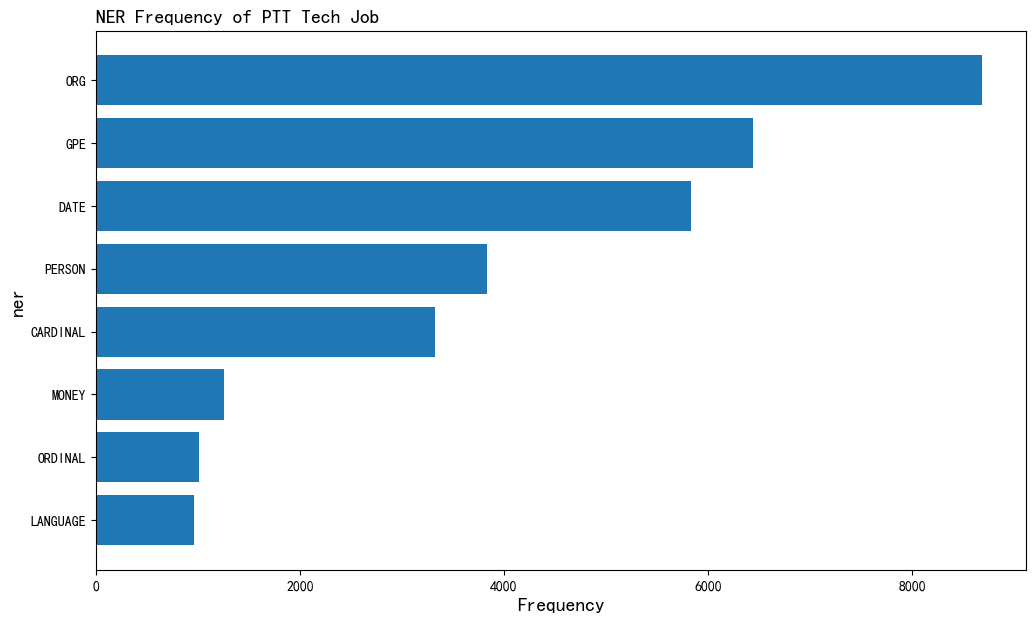

In [5]:
ner = ner_count['ner']
count = ner_count['count']

fig, ax = plt.subplots(figsize =(12, 7))
ax.barh(ner, count)
ax.invert_yaxis()
ax.set_title('NER Frequency of PTT Tech Job',loc ='left', size = 14)
ax.set_ylabel('ner', size = 14)
ax.set_xlabel('Frequency', size = 14)
fig.show()

#### 涉及到的人名(PERSON)

C:\Users\s2568\AppData\Local\Temp\ipykernel_19540\2044175467.py:21: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


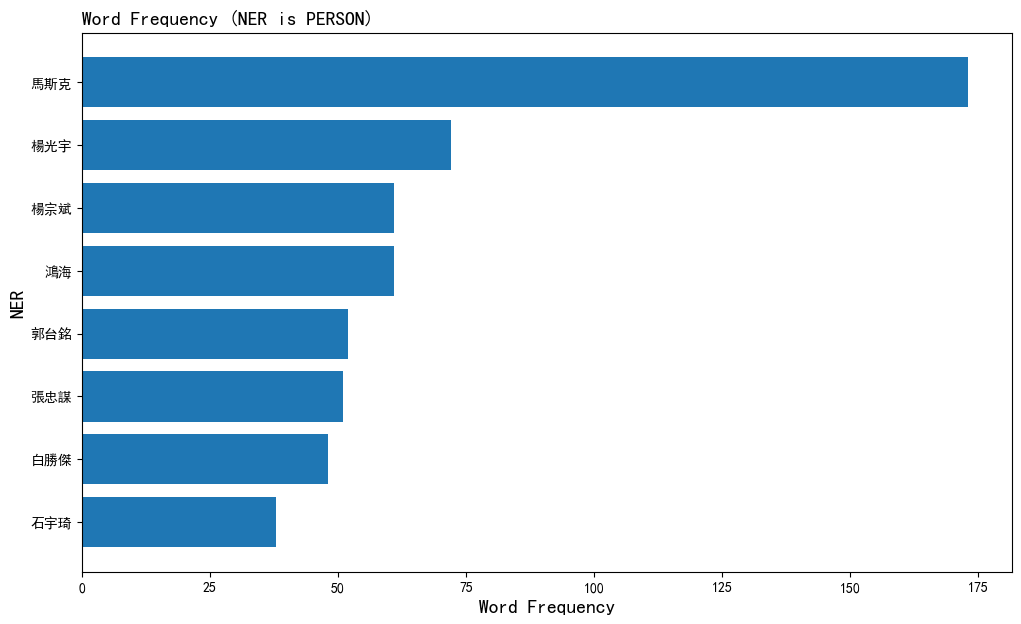

In [6]:
# 篩選ner為名詞的資料
l_noun = ["PERSON"]
PERSON = entity_table[entity_table.ner.isin(l_noun)]

# # 計算每個名詞提到的次數，選出前8個
ner_count = PERSON.groupby('word')['word'].agg(['count'])
ner_count = ner_count.sort_values(['count'],ascending=False)['count'].nlargest(8).reset_index()
ner_count

# 設定中文字形
plt.rcParams['font.sans-serif'] = ['SimHei'] 
word = ner_count['word']
count = ner_count['count']

fig, ax = plt.subplots(figsize =(12, 7))
ax.barh(word, count)
ax.invert_yaxis()
ax.set_title('Word Frequency (NER is PERSON)',loc ='left', size = 14)
ax.set_ylabel('NER', size = 14)
ax.set_xlabel('Word Frequency', size = 14)
fig.show()

#### 涉及到的組織(ORG)

C:\Users\s2568\AppData\Local\Temp\ipykernel_19540\3690618897.py:21: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


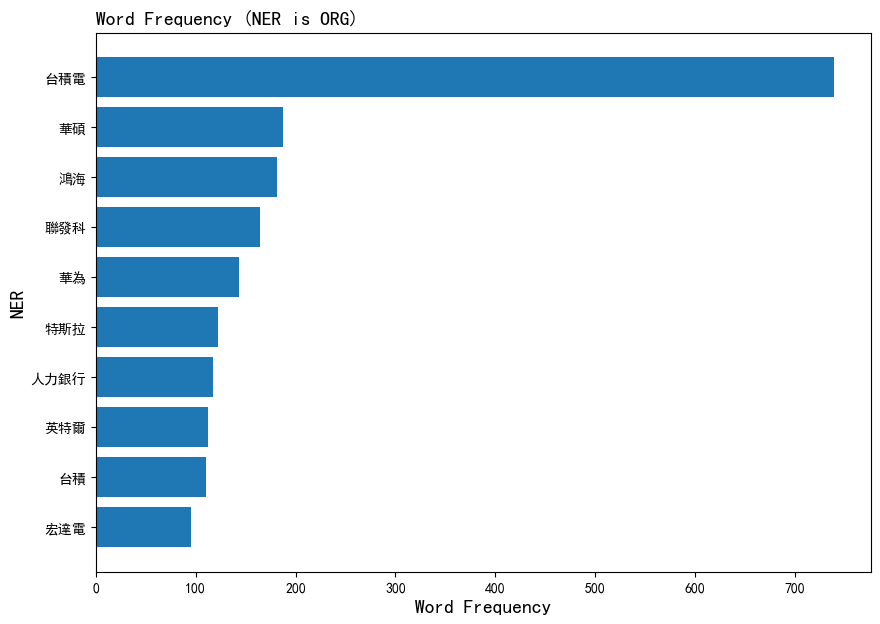

In [7]:
# 篩選ner為名詞的資料
l_noun = ["ORG"]
ORG = entity_table[entity_table.ner.isin(l_noun)]

# # 計算每個名詞提到的次數，選出前10個
ner_count = ORG.groupby('word')['word'].agg(['count'])
ner_count = ner_count.sort_values(['count'],ascending=False)['count'].nlargest(10).reset_index()
ner_count

# 設定中文字形
plt.rcParams['font.sans-serif'] = ['SimHei'] 
word = ner_count['word']
count = ner_count['count']

fig, ax = plt.subplots(figsize =(10, 7))
ax.barh(word, count)
ax.invert_yaxis()
ax.set_title('Word Frequency (NER is ORG)',loc ='left', size = 14)
ax.set_ylabel('NER', size = 14)
ax.set_xlabel('Word Frequency', size = 14)
fig.show()

#### 涉及到的民族、宗教、政治團體(NORP)

C:\Users\s2568\AppData\Local\Temp\ipykernel_19540\1258504230.py:21: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


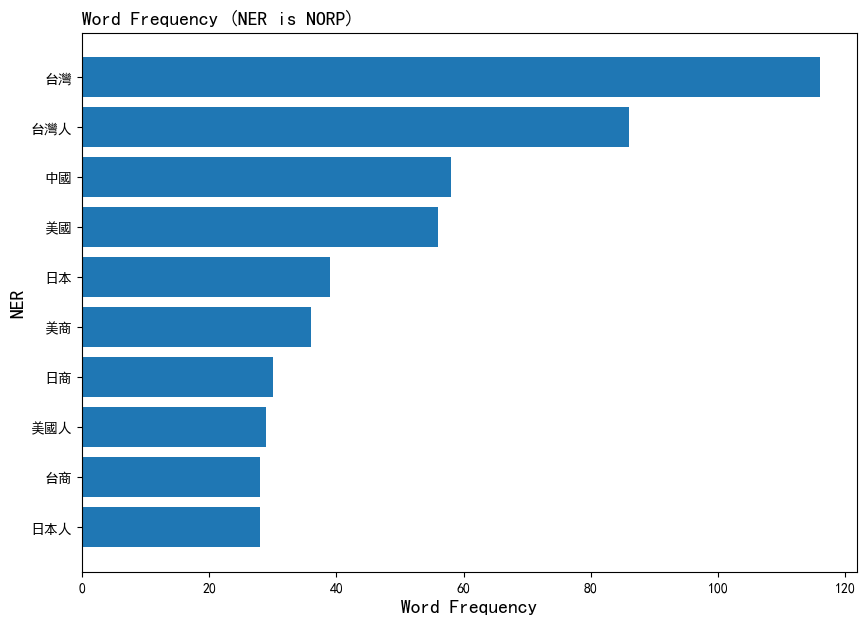

In [8]:
# 篩選ner為名詞的資料
l_noun = ["NORP"]
NORP = entity_table[entity_table.ner.isin(l_noun)]

# # 計算每個名詞提到的次數，選出前10個
ner_count = NORP.groupby('word')['word'].agg(['count'])
ner_count = ner_count.sort_values(['count'],ascending=False)['count'].nlargest(10).reset_index()
ner_count

# 設定中文字形
plt.rcParams['font.sans-serif'] = ['SimHei'] 
word = ner_count['word']
count = ner_count['count']

fig, ax = plt.subplots(figsize =(10, 7))
ax.barh(word, count)
ax.invert_yaxis()
ax.set_title('Word Frequency (NER is NORP)',loc ='left', size = 14)
ax.set_ylabel('NER', size = 14)
ax.set_xlabel('Word Frequency', size = 14)
fig.show()

In [25]:
keyword_list = ['美商']
foreign_company_selected = df[df['artContent'].str.contains('|'.join(keyword_list),regex=True)]
print(f"{' '.join(keyword_list)}：{foreign_company_selected.shape[0]}篇相關貼文")
foreign_company_selected.head(3)

美商：30篇相關貼文


,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource
7,8,https://www.ptt.cc/bbs/Tech_Job/M.1516292728.A...,[新聞]火狐開發商傳台灣裁員同業盼「自由的狐,2018-01-18 16:19:25,zzzz8931,Tech_Job,火狐開發商傳台灣裁員 同業盼「自由的狐狸」投效\nhttp://news.ltn.com.t...,"[{""cmtStatus"": ""→"", ""cmtPoster"": ""ken1325"", ""c...",1.160.23.84,2018-04-27 12:51:21,ptt
93,94,https://www.ptt.cc/bbs/Tech_Job/M.1525540586.A...,[新聞]科技人轉戰中國 美商周：超過30就太老,2018-05-05 17:10:21,zzzz8931,Tech_Job,科技人轉戰中國 美商周：超過30就太老\nhttps://tw.finance.appled...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""chocopie"", ""...",1.160.32.76,2018-05-17 10:47:16,ptt
95,96,https://www.ptt.cc/bbs/Tech_Job/M.1525772635.A...,[心得]精英/皮卡/嘉OO/可成/精聯/愛國者,2018-05-08 09:37:53,faceloser,Tech_Job,小魯背景是素有東方哈哈哈哈哈哈佛美稱的應屆社科學士畢，無任何科技業背景也無學長\n姐在相關產...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""Agclean"", ""c...",223.136.126.65,2018-05-17 10:47:16,ptt


### 3. 探索分析 - POS
#### POS 種類分析
查看辨識出哪幾種POS<br>
名詞對應: https://ckip.iis.sinica.edu.tw/service/corenlp/ （左上角的標記列表）

In [12]:
pos_table['pos'].unique()

array(['Nh', 'Na', 'Neu', 'DE', 'VH', 'COMMACATEGORY', 'Nd', 'SHI', 'Nf',
       'VC', 'Ncd', 'VE', 'VF', 'VD', 'Cbb', 'VA', 'D', 'Da', 'Nc', 'P',
       'Nb', 'VG', 'V_2', 'VJ', 'VK', 'VCL', 'A', 'Caa', 'Nes', 'VB',
       'Nep', 'Dfa', 'VL', 'Neqa', 'Ng', 'T', 'VHC', 'FW', 'Di', 'Cab',
       'Nv', 'VI', 'DM', 'I', 'Neqb', 'Dk', 'Cba', 'Dfb', 'VAC',
       'COLONCATEGORY', 'PARENTHESISCATEGORY', 'PERIODCATEGORY',
       'ETCCATEGORY'], dtype=object)

看看除了標點符號，大部分的POS都是哪一類

In [13]:
pos_filter = pos_table[~pos_table.pos.isin(['COMMACATEGORY', 'PARENTHESISCATEGORY', 'PERIODCATEGORY', 'COLONCATEGORY'])]

pos_count = pos_filter.groupby(['pos'])['pos'].count().reset_index(name='count').sort_values(['count'], ascending=False).head(12)
pos_count

,pos,count
16,Na,148001
5,D,72293
36,VC,54283
42,VH,38196
6,DE,31022
18,Nc,30017
30,P,27113
39,VE,21171
28,Nh,20226
26,Nf,18140


C:\Users\s2568\AppData\Local\Temp\ipykernel_19540\2478466374.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


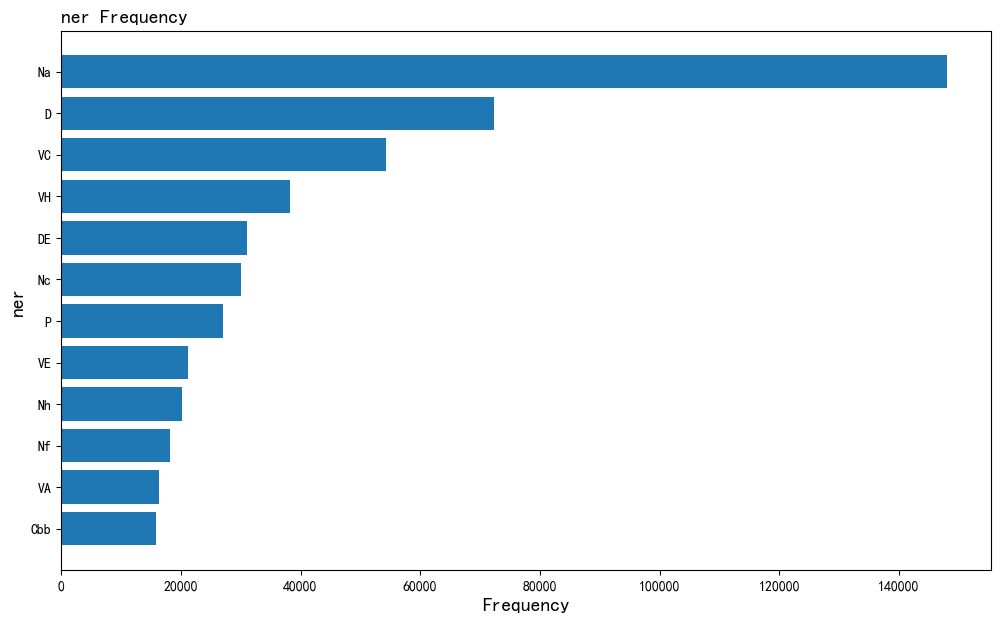

In [14]:
pos = pos_count['pos']
count = pos_count['count']

fig, ax = plt.subplots(figsize =(12, 7))
ax.barh(pos, count)
ax.invert_yaxis()
ax.set_title('ner Frequency',loc ='left', size = 14)
ax.set_ylabel('ner', size = 14)
ax.set_xlabel('Frequency', size = 14)
fig.show()

#### POS 常見詞性列表
+ 中研院列表: https://ckip.iis.sinica.edu.tw/service/corenlp/
    + Na: 普通名詞
    + D: 副詞
    + VC: 動作及物動詞
    + Nb: 專有名詞
    + FW: 外文
    + VH: 狀態不及物動詞
    + Nh: 代名詞
    + DE: 的之得地
    + P: 介詞
    + VA: 動作不及物動詞
    + T: 語助詞
    + SHI: 是

### 涉及到的名詞(Noun)
+ 找出談論「科技工作」時大部分討論到的專有名詞，探索大家的關注焦點。
+ 名詞可以分為「Na: 普通名詞」、「Nb: 專有名詞」等

In [15]:
# 篩選pos為名詞的資料
l_noun = ["Nb"] #,"Na"
noun = pos_table[pos_table.pos.isin(l_noun)]

# # 計算每個名詞提到的次數，選出前15個
noun_count = noun[['word']].groupby(['word'])['word'].count().reset_index(name='count').sort_values(['count'], ascending=False).head(15)
noun_count.head(10)

,word,count
414,台積電,877
2852,鴻海,361
2153,華碩,216
2039,聯發科,208
2792,馬斯克,179
1968,美光,163
408,台積,159
2149,華為,157
2827,高通,137
1655,特斯拉,134


C:\Users\s2568\AppData\Local\Temp\ipykernel_19540\502700507.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


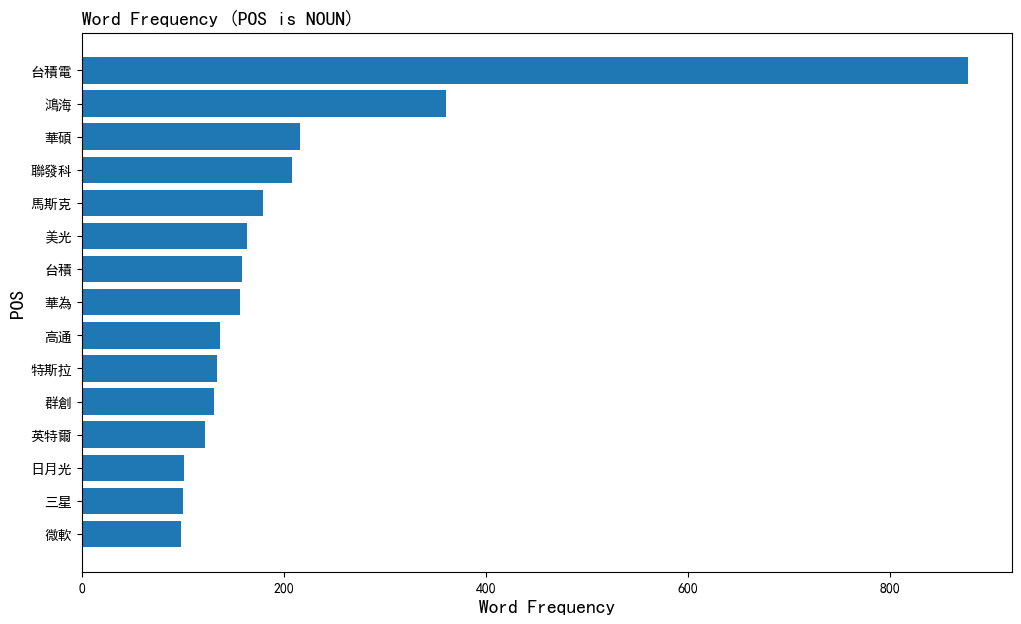

In [16]:
# 設定中文字形
plt.rcParams['font.sans-serif'] = ['SimHei'] 
word = noun_count['word']
count = noun_count['count']

fig, ax = plt.subplots(figsize =(12, 7))
ax.barh(word, count)
ax.invert_yaxis()
ax.set_title('Word Frequency (POS is NOUN)',loc ='left', size = 14)
ax.set_ylabel('POS', size = 14)
ax.set_xlabel('Word Frequency', size = 14)
fig.show()

### 涉及到的動詞(VERB)
+ 找出談論「科技工作」時大部分討論到的動詞，探索相關行為。
+ VC: 動作及物動詞、VH: 狀態不及物動詞、VA: 動作不及物動詞

In [17]:
l_verb = ["VC"] # ,"VH","VA"
verb = pos_table[pos_table.pos.isin(l_verb)] # 選取特定詞性
verb = verb[verb['word'].map(len) > 1] # 把長度為1的字去除掉

verb_count = verb[['word']].groupby(['word'])['word'].count().reset_index(name='count').sort_values(['count'], ascending=False).head(15)
verb_count

,word,count
3825,面試,3331
3026,裁員,1405
3552,進行,529
3730,開發,480
2473,發展,435
2563,研發,389
863,學習,349
2273,準備,349
3602,選擇,343
2063,服務,331


C:\Users\s2568\AppData\Local\Temp\ipykernel_19540\2587760616.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


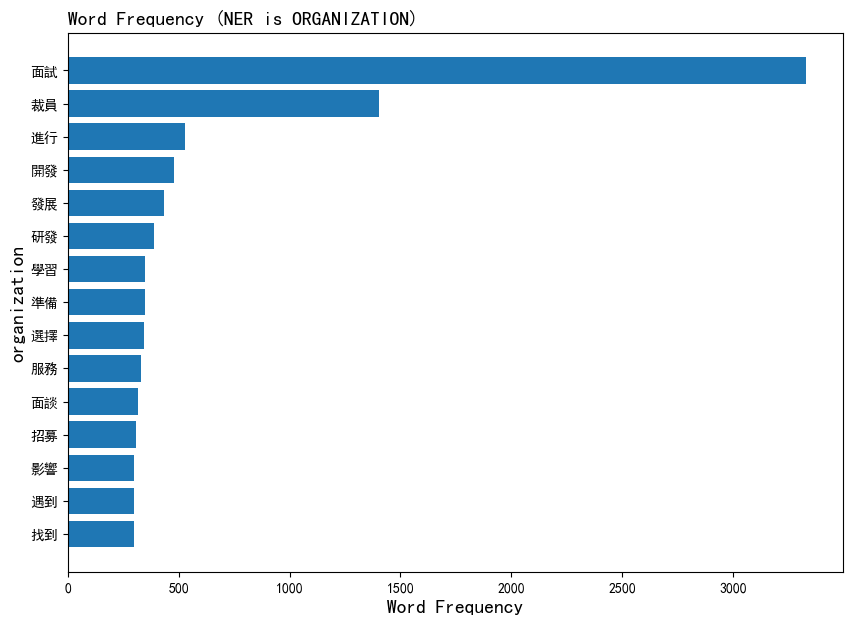

In [18]:
plt.rcParams['font.sans-serif'] = ['SimHei'] 
word = verb_count['word']
count = verb_count['count']

fig, ax = plt.subplots(figsize =(10, 7))
ax.barh(word, count)
ax.invert_yaxis()
ax.set_title('Word Frequency (NER is ORGANIZATION)',loc ='left', size = 14)
ax.set_ylabel('organization', size = 14)
ax.set_xlabel('Word Frequency', size = 14)
fig.show()

## 利用SnowNLP進行情緒分析

+ SnowNLP 針對中文設計，可以提取句子的情緒分類
+ 使用文件分類法，套件已預先用文集訓練模型以判斷情緒
+ 情緒值在 0~1之間，代表負面到正面
+ 官方github: https://github.com/isnowfy/snownlp

In [22]:
from snownlp import SnowNLP
s = SnowNLP('外商公司大裁員')
s.sentiments # 範圍在 0~ 1之間 (負面~正面)

0.46186224583808955

In [26]:
sentence_table = pd.read_csv("data/sentence_table_techjob.csv") #匯資料

sentiment_date = pd.merge(sentence_table,foreign_company_selected[['system_id','artDate','dataSource']],on='system_id',how='left').dropna()
sentiment_date.head()

,system_id,sentence,artDate,dataSource
291,8,火狐開發商傳台灣裁員同業盼自由的狐狸投效,2018-01-18 16:19:25,ptt
292,8,///////,2018-01-18 16:19:25,ptt
293,8,火狐瀏覽器開發商美商謀智驚傳台灣分公司裁員成後只剩人,2018-01-18 16:19:25,ptt
294,8,，今發布聲明表示，為符合亞洲新興市場消費者的利益需求，確實正在調整台灣,2018-01-18 16:19:25,ptt
295,8,團隊的營運結構，不過不願透露裁員人數,2018-01-18 16:19:25,ptt


In [27]:
def get_sentiment(sent):
    s = SnowNLP(sent)
    return s.sentiments

# 幫每句話加上情緒分數
sentiment_date['sentimentValue'] = sentiment_date.apply(lambda row : get_sentiment(row['sentence'],), axis = 1)
sentiment_date.head()

,system_id,sentence,artDate,dataSource,sentimentValue
291,8,火狐開發商傳台灣裁員同業盼自由的狐狸投效,2018-01-18 16:19:25,ptt,0.979530
292,8,///////,2018-01-18 16:19:25,ptt,0.500000
293,8,火狐瀏覽器開發商美商謀智驚傳台灣分公司裁員成後只剩人,2018-01-18 16:19:25,ptt,0.956112
294,8,，今發布聲明表示，為符合亞洲新興市場消費者的利益需求，確實正在調整台灣,2018-01-18 16:19:25,ptt,0.013968
295,8,團隊的營運結構，不過不願透露裁員人數,2018-01-18 16:19:25,ptt,0.079608


In [28]:
# 看一下情緒的分布
sentiment_date['sentimentValue'].describe()

count    1.483000e+03
mean     3.664178e-01
std      3.294251e-01
min      4.913576e-07
25%      4.925047e-02
50%      2.880483e-01
75%      6.192776e-01
max      9.999724e-01
Name: sentimentValue, dtype: float64

<Axes: >

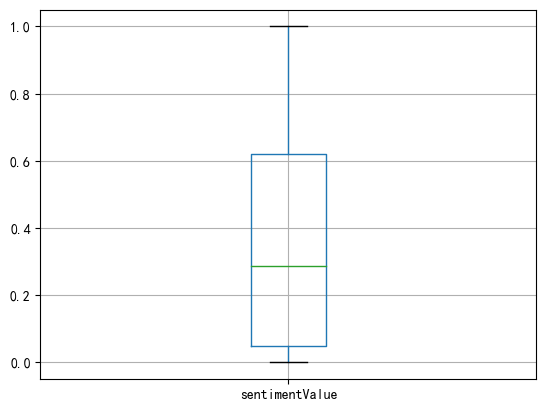

In [29]:
# 情緒分布的盒狀圖
boxplot = sentiment_date.boxplot(column=['sentimentValue'], showfliers=False)
boxplot

將每個月的情緒分數取平均，並轉換時間格式為年月

In [37]:
sent_date = sentiment_date.copy()
sent_date['artDate'] =  pd.to_datetime(sentiment_date['artDate']).dt.to_period('M')

sentiment_count = sent_date.groupby(['artDate'])['sentimentValue'].mean().reset_index()


sentiment_count.sort_values(['sentimentValue'], ascending=False).head(15)

,artDate,sentimentValue
23,2022-09,0.528996
9,2019-08,0.509846
5,2019-01,0.479125
20,2022-01,0.461209
15,2020-12,0.435876
17,2021-03,0.435819
25,2022-12,0.425321
0,2018-01,0.418875
12,2020-03,0.417119
8,2019-05,0.402459


C:\Users\s2568\AppData\Local\Temp\ipykernel_19540\3287014777.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


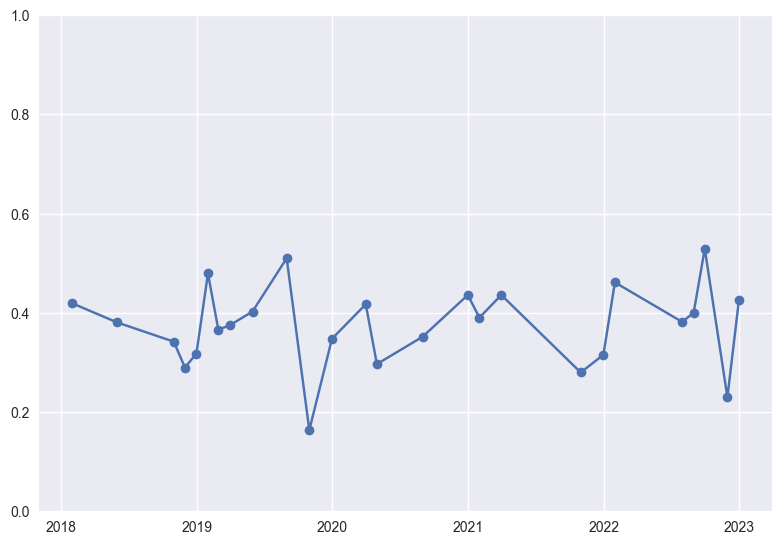

In [38]:
# 平均情緒分數時間趨勢
plt.style.use('seaborn')

months = sentiment_count['artDate']
y = sentiment_count['sentimentValue']

plt.plot_date(months, y, linestyle='solid')
plt.gcf().autofmt_xdate
plt.tight_layout()
plt.ylim(0,1)

plt.show()

### 詞彙探索
從上圖中可以發現 2022年9月 的情緒分數相對高，我們把這個月的正面句子挑出來看看他們都用甚麼詞。

In [53]:
# 篩時間
filter_sentiment = sent_date[sent_date['artDate']=='2022-09']
filter_sentiment = filter_sentiment.loc[filter_sentiment['sentimentValue'] > 0.7]

filter_sentiment.head()

,system_id,sentence,artDate,dataSource,sentimentValue
57506,1494,"公司風氣陸資公司,土皇帝,皇親國戚內鬥制公司高層偏文盲加流氓",2022-09,ptt,0.999740
57508,1494,公司感覺正派很多,2022-09,ptt,0.978254
57510,1494,"公司風氣美商公司,相對員工文化上水準高管理平行",2022-09,ptt,0.988518
57512,1494,補充下我朋友很廢,2022-09,ptt,0.886041


In [54]:
# 把時間分數和之前斷詞的token table做 join
neg_words = pd.merge(filter_sentiment,pos_table,on='system_id',how='left')
neg_words = neg_words[['system_id','sentimentValue','word']]
neg_words.head()

,system_id,sentimentValue,word
0,1494,0.99974,幫
1,1494,0.99974,朋友
2,1494,0.99974,上來
3,1494,0.99974,問
4,1494,0.99974,兩


In [55]:
# 篩選掉只有單個字元的結果
neg_words = neg_words[neg_words.apply(lambda x: len(x['word'])>1, axis=1)]

### 文字雲

In [56]:
# 自定停用字
with open('dict/stopwords.txt', encoding="utf-8") as f:
    stop_words = f.read().splitlines()

print(stop_words)

['$', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '?', '_', '“', '”', '、', '。', '《', '》', '一', '一些', '一何', '一切', '一則', '一方面', '一旦', '一來', '一樣', '一般', '一轉眼', '萬一', '上', '上下', '下', '不', '不僅', '不但', '不光', '不單', '不只', '不外乎', '不如', '不妨', '不盡', '不盡然', '不得', '不怕', '不惟', '不成', '不拘', '不料', '不是', '不比', '不然', '不特', '不獨', '不管', '不至於', '不若', '不論', '不過', '不問', '與', '與其', '與其說', '與否', '與此同時', '且', '且不說', '且說', '兩者', '個', '個別', '臨', '為', '為了', '為什麼', '為何', '為止', '為此', '為著', '乃', '乃至', '乃至於', '麼', '之', '之一', '之所以', '之類', '烏乎', '乎', '乘', '也', '也好', '也罷', '了', '二來', '於', '於是', '於是乎', '云云', '云爾', '些', '亦', '人', '人們', '人家', '什麼', '什麼樣', '今', '介於', '仍', '仍舊', '從', '從此', '從而', '他', '他人', '他們', '以', '以上', '以為', '以便', '以免', '以及', '以故', '以期', '以來', '以至', '以至於', '以致', '們', '任', '任何', '任憑', '似的', '但', '但凡', '但是', '何', '何以', '何況', '何處', '何時', '余外', '作為', '你', '你們', '使', '使得', '例如', '依', '依據', '依照', '便於', '俺', '俺們', '倘', '倘使', '倘或', '倘然', '倘若', '借', '假使', '假如', '假若', '儻然', '像', '兒', '先不先', '光是', '全體', '全部', '

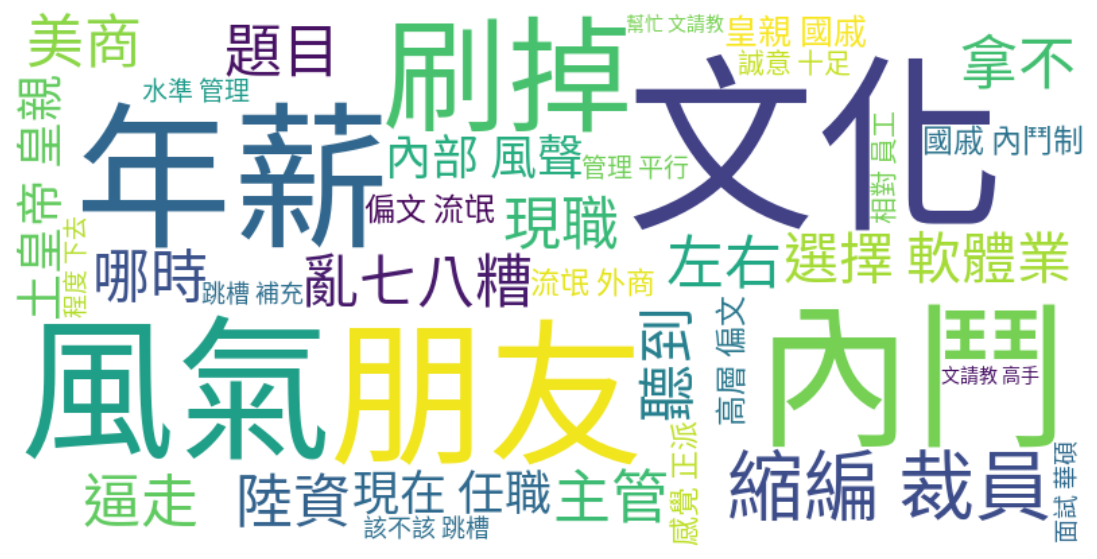

In [58]:
# 匯入自訂的 stop words (預設只有英文的)
stop_words_pos = stop_words
stop_words_pos.extend(( '公司', '工作', '請問'))
stop_words_pos = set(stop_words_pos)

# 設定中文字形
font_path = "data/SourceHanSansTW-Regular.otf"

# 可以設定字型大小和背景顏色
wordcloud = WordCloud(
                stopwords=stop_words_pos,font_path=font_path,width=800, height = 400, max_words=100, background_color="white")

wordcloud.generate(' '.join(neg_words['word']))
# Display the generated image:
plt.figure(figsize = (14,7))
plt.imshow(wordcloud, interpolation="bilinear")

plt.axis("off")
plt.show()